# Защита персональных данных клиентов страховой компании

Необходимо защитить персональные данные клиентов страховой компании. Разработать такой метод преобразования данных, чтобы по ним было тяжело восстановить исходную информацию и при этом не менялось качество линейной регрессии.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from IPython.display import Image, display

## Изучение данных и предобработка

In [2]:
insurance = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP9\\insurance.csv')

In [3]:
insurance.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Переименовываю столбцы для удобства дальнейшей работы:

In [4]:
insurance.columns = ['gender', 'age', 'income', 'family_members', 'insurance_payments']

In [5]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_payments  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Тип колонок age и income меняю на int:

In [6]:
insurance[['age', 'income']] = insurance[['age', 'income']].astype('int64')

In [7]:
insurance.describe()

,gender,age,income,family_members,insurance_payments
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


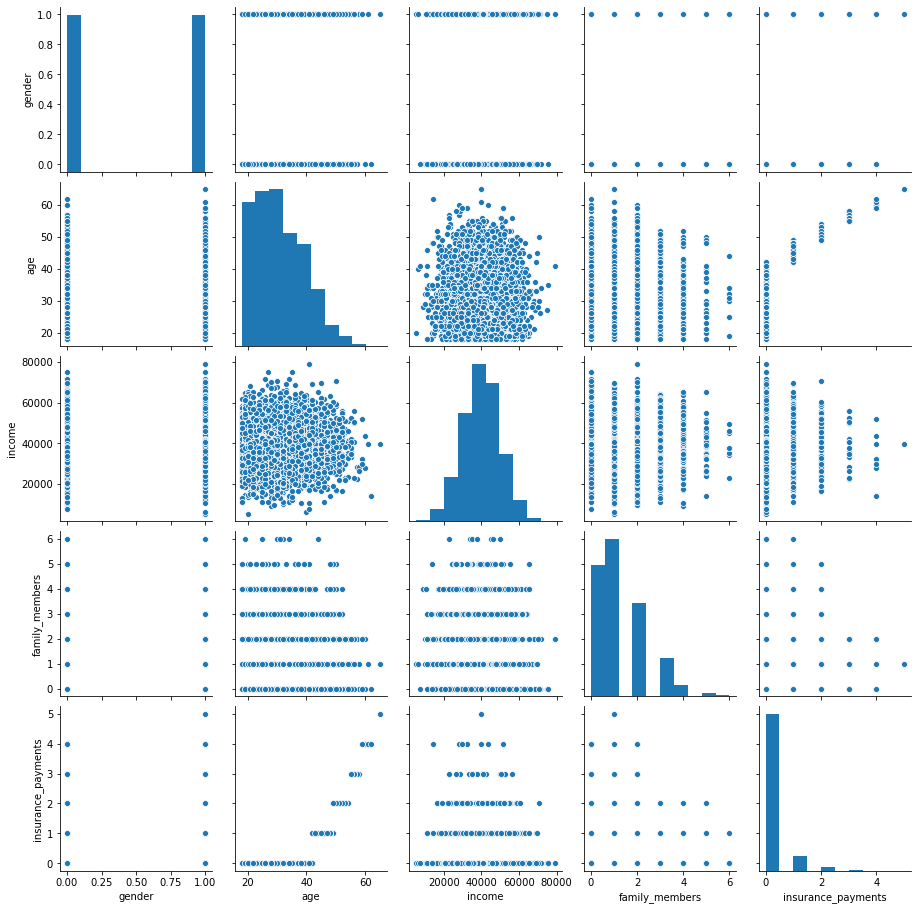

In [8]:
sns.pairplot(insurance);

In [9]:
insurance[insurance.duplicated() == True]['income'].count()

153

In [10]:
print(insurance.shape)
insurance = insurance.drop_duplicates().reset_index(drop=True)
print(insurance.shape)

(5000, 5)
(4847, 5)


Аномалий в данных не обнаружено. Удалены 153 дубликата.

## Изменится ли качество линейной регрессии, если признаки умножить на случайную обратимую матрицу?

### Доказательство:

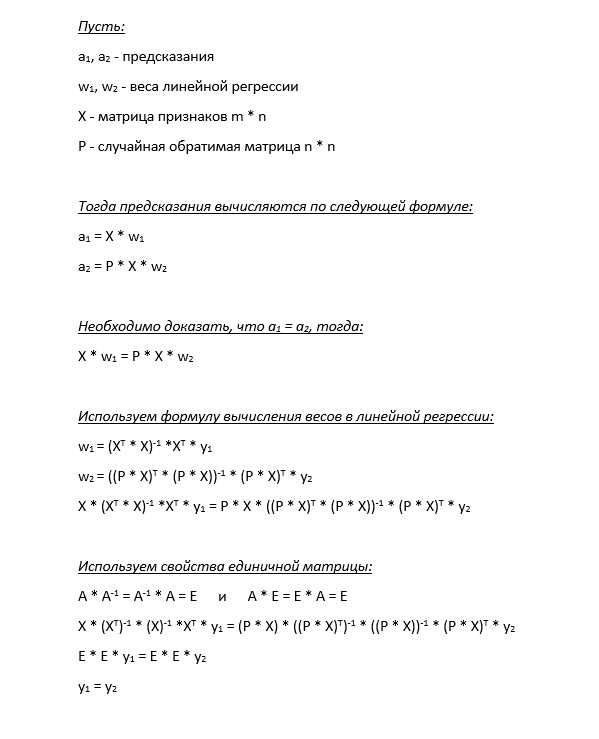

In [11]:
display(Image(filename='proof.png', embed=True))

Вывод: При умножении матрицы признаков на случайную обратимую матрицу, качество линейной регрессии не изменится.

## Преобразовываю данные

Используя доказательство из предыдущего шага, преобразую исходный датафрейм, умножим его на случайную обратимую матрицу.

In [12]:
'''
Функция создания случайной обратимой матрицы
Вводные параметры:
size - размер матрицы, где m=n
a, b - диапазон для генерации случайных целых чисел от a до b
rs - использовать значение RandomState для воспроизводимости расчетов
'''

def create_reversible_matrix(size, a, b, rs=None):
    is_reversible = False
    if rs!=None:
        rdm = np.random.RandomState(rs)
    else:
        rdm = random
    while is_reversible == False:
        final_list = []
        while len(final_list) < size:
            temp_list = []
            while len(temp_list) < size:
                temp_list.append(rdm.randint(a, b))
            final_list.append(temp_list)
        try:
            np.linalg.inv(np.array(final_list))
            is_reversible = True
        except:
            if rs!=None:
                raise ValueError('Для внесенного параметра rs (RandomState) матрица необратима, необходимо выбрать другое \
                                  значение rs или другой диапазон случайных чисел')
            else:
                pass
    return np.array(final_list)

Создаю случайную обратимую матрицу:

In [13]:
matrix = create_reversible_matrix(4, -100, 100, 0)
matrix

array([[ 72, -53,  17,  92],
       [-33,  95,   3, -91],
       [-79, -64, -13, -30],
       [-12,  40, -42,  93]])

Разбиваю исходный датафрейм на два: один с признаками, второй с таргетом:

In [14]:
x_insurance = insurance.drop('insurance_payments', axis=1)
y_insurance = insurance['insurance_payments']

Создаю матрицу из датафрейма с признаками:

In [15]:
x_insurance_matrix = np.array(x_insurance)
x_insurance_matrix

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]], dtype=int64)

In [16]:
x_insurance_matrix.shape

(4847, 4)

Матрицу c признаками умножаю на случайную обратимую матрицу:

In [17]:
x_insurance_matrix_transformed = x_insurance_matrix.dot(matrix)
x_insurance_matrix_transformed

array([[-3919693, -3170518,  -644702, -1491546],
       [-3003530, -2427590,  -493904, -1144093],
       [-1659957, -1341245,  -272913,  -632639],
       ...,
       [-2678784, -2167620,  -440724, -1018634],
       [-2583990, -2090643,  -425143,  -982631],
       [-3208264, -2595753,  -527741, -1220363]], dtype=int64)

Преобразованный датафрейм:

In [18]:
x_insurance_transformed = pd.DataFrame(x_insurance_matrix_transformed)
x_insurance_transformed.head()

,0,1,2,3
0,-3919693,-3170518,-644702,-1491546
1,-3003530,-2427590,-493904,-1144093
2,-1659957,-1341245,-272913,-632639
3,-3295017,-2666725,-542121,-1252725
4,-2062752,-1667793,-339199,-785456


## Обучаю линейную регрессию на исходных и преобразованных данных

Готовлю данные:

In [19]:
x_insurance_train, x_insurance_test, y_insurance_train, y_insurance_test = train_test_split(x_insurance, y_insurance, 
                                                                                            random_state=12345)
x_insurance_train.shape, x_insurance_test.shape, y_insurance_train.shape, y_insurance_test.shape

((3635, 4), (1212, 4), (3635,), (1212,))

In [20]:
x_insurance_transformed_train, x_insurance_transformed_test = train_test_split(x_insurance_transformed, random_state=12345)

x_insurance_transformed_train.shape, x_insurance_transformed_test.shape

((3635, 4), (1212, 4))

In [21]:
display(x_insurance_train.head(5))
display(x_insurance_transformed_train.head(5))

,gender,age,income,family_members
4460,0,28,54500,2
3773,1,38,50700,1
4561,0,24,28000,1
1385,0,47,38800,0
724,0,40,32500,1


,0,1,2,3
4460,-4306448,-3485260,-708500,-1637362
3773,-4006494,-3241203,-659011,-1524273
4561,-2212804,-1789680,-363970,-842091
1385,-3066751,-2478735,-504259,-1168277
724,-2568832,-2076160,-422422,-978547


In [22]:
clf1 = LinearRegression()
clf2 = LinearRegression()

In [23]:
clf1.fit(x_insurance_train, y_insurance_train)
clf2.fit(x_insurance_transformed_train, y_insurance_train)

LinearRegression()

In [24]:
prediction1 = clf1.predict(x_insurance_test)
prediction2 = clf2.predict(x_insurance_transformed_test)

In [25]:
clf1_r2 = r2_score(y_insurance_test, prediction1)
clf2_r2 = r2_score(y_insurance_test, prediction2)
print(f'R2 score на исходных данных: {clf1_r2:.5f}')
print(f'R2 score на преобразованных данных: {clf2_r2:.5f}')

R2 score на исходных данных: 0.42308
R2 score на преобразованных данных: 0.42308


Качество работы модели действительно не изменилось, доказательство подкреплено реальным примером.

## Восстановление исходных данных

In [26]:
insurance_recovered = x_insurance_transformed.dot(np.linalg.inv(matrix))
insurance_recovered[4] = y_insurance

In [27]:
insurance_recovered = round(insurance_recovered).astype('int64')
insurance_recovered.columns = ['gender', 'age', 'income', 'family_members', 'insurance_payments']
print('Восстановленный исходный датафрейм:')
display(insurance_recovered.head(5))
print('Реальный исходный датафрейм:')
display(insurance.head(5))
print('Проверка:')
display(insurance.head(5) == insurance_recovered.head(5))
display((insurance == insurance_recovered).apply(pd.Series.value_counts))

Восстановленный исходный датафрейм:


,gender,age,income,family_members,insurance_payments
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


Реальный исходный датафрейм:


,gender,age,income,family_members,insurance_payments
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


Проверка:


,gender,age,income,family_members,insurance_payments
0,True,True,True,True,True
1,True,True,True,True,True
2,True,True,True,True,True
3,True,True,True,True,True
4,True,True,True,True,True


,gender,age,income,family_members,insurance_payments
True,4847,4847,4847,4847,4847


## Вывод

В ходе работы над проектом, приведено доказательство, что при умножении матрицы с признаками размером m * n на случайную обратимую матрицу n * n, качество линейной регрессии не изменится. Также в проекте приведен пример преобразования и проверка качества моделей линейной регрессии на исходных и преобразованных данных. Этот метод можно использовать для защиты персональных данных, тк по преобразованному датафрейму будет тяжело восстановить исходные данные.